In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Load your data
essays = pd.read_csv('../llm-detect-ai-generated-text/train_essays.csv')
prompts = pd.read_csv('../llm-detect-ai-generated-text/train_prompts.csv')
xsum_data = pd.read_csv('../additional_data/xsum/xsum-gen-model=mistral-7b-v0.1-n=5000.csv')
xsum_data.dropna(inplace=True)
xsum_data.reset_index(drop=True, inplace=True)

# Get name of dataset
dataset_name = 'xsum-gen-model-mistral'

# Merge essays with prompts based on 'prompt_id'
data = essays.merge(prompts, on='prompt_id', how='left')
data['combined_text'] = data['prompt_name'] + " " + data['instructions'] + " " + data['text']

# Split data into train and validation sets
train_data, val_data = train_test_split(xsum_data, test_size=0.3, random_state=42)


In [11]:
print(xsum_data.isna().sum())

text         0
generated    0
dtype: int64


In [12]:
from transformers import DebertaTokenizer
from torch.utils.data import Dataset, DataLoader
import torch

# Initialize tokenizer
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')  

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True
        )
        return {
            'input_ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Creating the dataset
train_dataset = TextDataset(train_data['text'].tolist(), train_data['generated'].tolist(), tokenizer)
val_dataset = TextDataset(val_data['text'].tolist(), val_data['generated'].tolist(), tokenizer)

# DataLoader setup
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


In [13]:
from transformers import DebertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup

# Model initialization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "mps" if torch.backends.mps.is_available() else device
print(f'Using device: {device}')
model = DebertaForSequenceClassification.from_pretrained('microsoft/deberta-base', num_labels=2)  
model.to(device)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
total_steps = len(train_loader) * 3  # num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Prediction data
predictions = []
true_labels = []

# Training loop with accuracy tracking
for epoch in range(3):  # num_epochs
    model.train()
    total_train_loss = 0
    total_train_correct = 0
    total_train_examples = 0

    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_train_loss += loss.item()

        preds = torch.argmax(outputs.logits, dim=-1)
        total_train_correct += (preds == batch['labels']).sum().item()
        total_train_examples += batch['labels'].size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

    train_accuracy = total_train_correct / total_train_examples
    print(f'Epoch {epoch+1}, Train Loss: {total_train_loss / len(train_loader)}, Train Accuracy: {train_accuracy}')

    # Validation step
    model.eval()
    total_val_loss = 0
    total_val_correct = 0
    total_val_examples = 0

    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            total_val_loss += outputs.loss.item()

            preds = torch.argmax(outputs.logits, dim=-1)
            total_val_correct += (preds == batch['labels']).sum().item()
            total_val_examples += batch['labels'].size(0)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(batch['labels'].cpu().numpy())

    val_accuracy = total_val_correct / total_val_examples
    print(f'Validation Loss: {total_val_loss / len(val_loader)}, Validation Accuracy: {val_accuracy}')


Using device: mps


Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/miniconda3/envs/llm-detect-deberta/lib/python3.9/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Train Loss: 0.22265977427310177, Train Accuracy: 0.9189768505287225
Validation Loss: 0.1870465995570024, Validation Accuracy: 0.9346666666666666
Epoch 2, Train Loss: 0.15090768459033488, Train Accuracy: 0.9449842812232067
Validation Loss: 0.13231380786575997, Validation Accuracy: 0.95
Epoch 3, Train Loss: 0.09202697269824732, Train Accuracy: 0.9652757930837382
Validation Loss: 0.12013576116156764, Validation Accuracy: 0.9533333333333334


In [54]:
def displayConfusionMatrix(y_true, y_pred, dataset, aa=""):
    # Convert lists to NumPy arrays if not already
    y_true = np.array(y_true) if isinstance(y_true, list) else y_true
    y_pred = np.array(y_pred) if isinstance(y_pred, list) else y_pred

    # Calculate F1 score only for binary classification
    if y_pred.ndim == 1 and len(set(y_pred)) == 2:
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        f1 = 2 * tp / (2 * tp + fp + fn)
        print("F1 Score:", f1)
    
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        display_labels=["Not Generated", "Generated"],
        cmap=plt.cm.Blues
    )
    plt.title(f"Confusion Matrix: {dataset}, F1 Score: {str(f1.round(2))}")
    plt.tight_layout()
    plt.savefig(f'../confusion_matrices/{dataset_name}{aa}.png')
    plt.show()
    
    

F1 Score: 0.9522184300341296


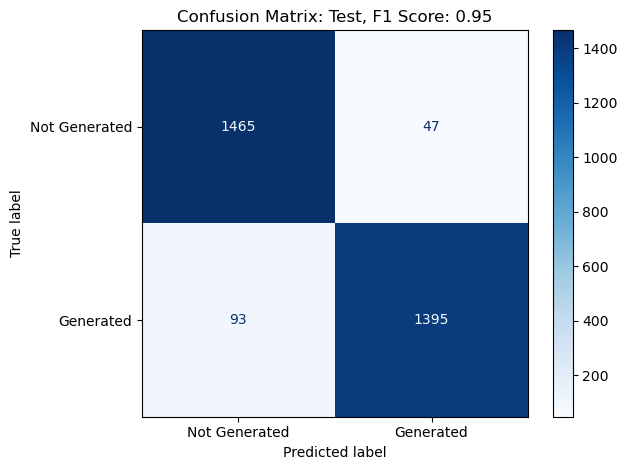

In [55]:
displayConfusionMatrix(true_labels, predictions, "Test")


In [24]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load T5 model for paraphrasing
t5_tokenizer = T5Tokenizer.from_pretrained('t5-base')
t5_model = T5ForConditionalGeneration.from_pretrained('t5-base')
t5_model.eval()
t5_model.to(device)

def paraphrase_text(texts, t5_model, tokenizer, max_length=200, batch_size=8):
    """ Function to generate paraphrased text using T5 in batches """
    paraphrased_texts = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        input_ids = tokenizer(batch_texts, max_length=max_length, padding=True, return_tensors="pt").input_ids.to(t5_model.device)
        paraphrased_ids = t5_model.generate(input_ids, max_length=max_length, num_return_sequences=1, num_beams=2)
        for j, g in enumerate(paraphrased_ids):
            try:
                paraphrased_text = tokenizer.decode(g, skip_special_tokens=True)
                if not paraphrased_text:  # Check if paraphrased text is empty
                    raise ValueError("Empty paraphrase generated")
            except:
                paraphrased_text = batch_texts[j]  # Fallback to the original text if paraphrasing fails
            paraphrased_texts.append(paraphrased_text)
    return paraphrased_texts

def paraphrase_and_prepare_data(validation_data, model, tokenizer):
    """ Function to paraphrase and prepare data for DataLoader """
    
    # Ensure text entries are valid strings
    val_data_reset = validation_data.reset_index(drop=True)
    
    # Paraphrase the 'text' part of the validation data
    paraphrased_texts = paraphrase_text(validation_data['text'].tolist(), model, tokenizer)

    # Add paraphrased text as a new column in the validation data
    paraphrased_texts_df = pd.DataFrame({'text': paraphrased_texts})

    # # Combine the paraphrased text with the prompt and instructions
    # val_data_reset['paraphrased_text'] = val_data_reset['prompt_name'].fillna('').str.cat(paraphrased_texts_df['text'].fillna(''), sep=' ')

    # Add paraphrased text as a new column in the validation data without the prompt and instructions
    val_data_reset['paraphrased_text'] = paraphrased_texts_df['text']
    
    return val_data_reset

# Apply paraphrasing and preparation to the validation data
# paraphrased_val_data = paraphrase_and_prepare_data(val_data, t5_model, t5_tokenizer)

# # Use your existing TextDataset class for the paraphrased data
# paraphrased_val_dataset = TextDataset(paraphrased_val_data['paraphrased_text'].tolist(), paraphrased_val_data['generated'].tolist(), tokenizer)

# # DataLoader for the paraphrased validation dataset
# paraphrased_val_loader = DataLoader(paraphrased_val_dataset, batch_size=8, shuffle=False)

paraphrased_val_data = paraphrase_and_prepare_data(val_data, t5_model, t5_tokenizer)
paraphrased_val_dataset = TextDataset(paraphrased_val_data['paraphrased_text'].tolist(), paraphrased_val_data['generated'].tolist(), tokenizer)
paraphrased_val_loader = DataLoader(paraphrased_val_dataset, batch_size=8, shuffle=False)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/opt/miniconda3/envs/llm-detect-deberta/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2706: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Accuracy on Paraphrased Data: 0.6016666666666667


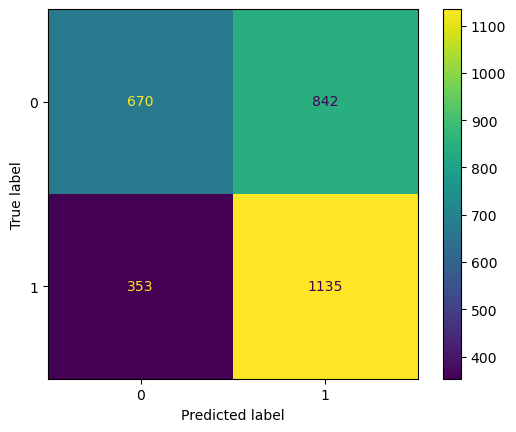

In [29]:
# Prediction data for the paraphrased validation
predictions_aa = []
true_labels_aa = []

# Evaluate existing dataset against adversarial attacks
def evaluate_model(model, dataloader):
    model.eval()
    total_correct = 0
    total_examples = 0
    model.to(device)

    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            preds = torch.argmax(outputs.logits, dim=-1)
            total_correct += (preds == batch['labels']).sum().item()
            total_examples += batch['labels'].size(0)
            predictions_aa.extend(preds.cpu().numpy())
            true_labels_aa.extend(batch['labels'].cpu().numpy())

    accuracy = total_correct / total_examples
    return accuracy

# Evaluate your DeBERTa model on the paraphrased validation data
accuracy = evaluate_model(model, paraphrased_val_loader)
print(f'Accuracy on Paraphrased Data: {accuracy}')
conf_matrix_aa = confusion_matrix(true_labels_aa, predictions_aa)

F1 Score: 0.6551226551226551


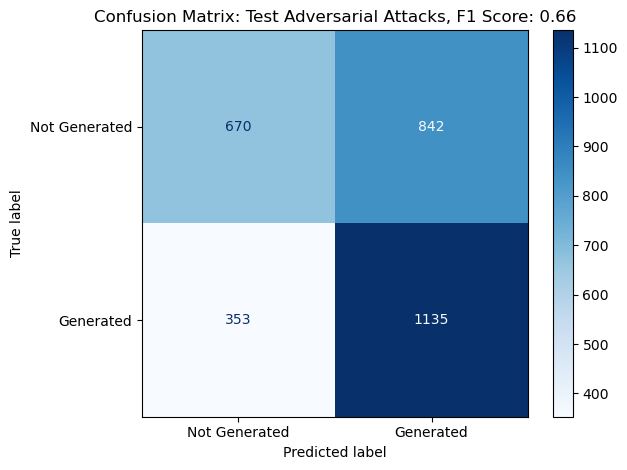

In [56]:
displayConfusionMatrix(true_labels_aa, predictions_aa, "Test Adversarial Attacks", "_aa")

In [57]:
# Save paraphrased data to a CSV file
paraphrased_val_data.to_csv(f'../adversarial_data/{dataset_name}-paraphrased_val_data.csv', index=False)

# Save the model
# model.save_pretrained('deberta-base-xsum-mistral-7b-v0.1')

# # Save the tokenizer
# tokenizer.save_pretrained('deberta-base-xsum-mistral-7b-v0.1')